# Hands-on3 (Video Processing, Facial Landmark, Resp Tracking, and RPPG)

---

Pada hands-on kali ini anda akan melakukan beberapa hal:
* Membaca video dari file
* Membuat gambar dari video
* Menghitung jumlah pernapasan dengan melihat pergerakan dada
* Menghitung detak jantung dengan menggunakan RPPG

## Prerequisites : Merekam Video 
> Sebelum memulai melakukan hands-on, anda harus merekam video wajah anda dengan durasi 60 detik. Anda dapat mengajak teman / keluarga anda untuk membantu dalam proses perekaman. 

Hal-hal yang perlu diperhatikan dalam perekaman video:
1. Rekamlah sebuah video yang berdurasi kira-kira 60 detik dengan kamera ponsel. Toleransi durasi adalah 63 detik.
   
2. Resolusi video haruslah tepat 1920x1080 dengan FPS 30.
3. Gunakan tripod / phone holder agar video tetap stabil
4. Lihat contoh gambar untuk posisi framing yang benar

<div align="center">
    <p style="align: center">Toby honest reaction ketika datasetnya dipake.</p>    
    <img src="media/sample_toby.jpg" alt="Contoh Framing" style="width:30%;">
</div>

1. Pastikan merekam dalam kondisi pencahayaan yang cukup (cahaya alami matahari lebih disarankan)   
2.  Anda harus duduk dengan tegak dan bersandar di kursi dan berada di tengah frame. Letakkan kedua tangan di atas lutut anda.
3. Selama perekaman, mintalah teman / keluarga anda untuk menghitung berapa kali anda bernafas selama 60 detik. Bukan hanya sekedar menghitung, teman / keluarga anda harus mencatat pada detik keberapa anda mulai menghembuskan nafas. Oleh karena itu, pastikan teman / keluarga anda menggunakan stopwatch pada HP mereka. (Tekan `LAP` setiap kali anda mulai menghembuskan nafas).
4. Pindahkan catatan tersebut ke dalam `csv` dengan format sebagai berikut:

```markdown
| Nafas-ke | Second | Milisecond |
|----------|--------|-----------|
| 1        | 0      | 0         |
| 2        | 10     | 0         |
| 3        | 20     | 0         |
| 4        | 30     | 0         |
| 5        | 40     | 0         |
| 6        | 50     | 0         |
| 7        | 60     | 0         |
```



### Pre-requisite Library

Karena kita bakal bekerja dengan hal baru, sebaiknya install beberapa library berikut

```python
pip install mediapipe # For mediapipe framework
pip install opencv-python # OpenCV
pip install scipy # Signal processing
pip install numpy # Numpy
```

**Penjelasan terkait library-library baru yang digunakan pada Hands-on 3:**

- **OpenCV** 📸: Library untuk pengolahan citra dan video. Digunakan untuk membaca video, mendeteksi wajah, dan menampilkan hasil.
- **MediaPipe** 🧠: Framework dari Google untuk deteksi pose, wajah, tangan, dll. Pada modul ini, digunakan untuk mendeteksi landmark wajah secara real-time guna mengekstrak area tertentu (seperti dahi atau pipi) yang digunakan untuk rPPG (remote photoplethysmography).
- **SciPy** 📈: Library ilmiah yang menyediakan fungsi untuk analisis sinyal. Berguna untuk filtering, transformasi sinyal (misalnya FFT atau detrending), dan proses lanjutan untuk ekstraksi sinyal pernapasan dari sinyal rPPG.
- **NumPy** 🧮: Library fundamental untuk komputasi numerik di Python. Digunakan untuk manipulasi array, operasi matematis, dan penyimpanan data sinyal rPPG dan pernapasan dalam bentuk efisien.


## Pre-requisite Models.

Mediapipe bekerja dengan menggunakan model external untuk **face detection** dan **pose detection**. Jadi silahkan download dan simpan dulu filenya dari [Github Informatika Itera](https://github.com/informatika-itera/if3024-handson/tree/main/2025-notebooks/models)

Model yang digunakan
- blaze_face_short_range.tflite
- pose_landmarker.task

### RPPG - *The Art of Touching Without Touch*

---

RPPG (Remote Photoplethysmography) adalah metode untuk mengambil sinyal denyut di bagian tubuh menggunakan metode *remote* (jarak jauh), tanpa menyentuh langsung kulit.

Tau Pulse Oximeter atau benda di bawah jam tangan? Itu disebut sensor **Photoplethysmography (PPG)**.

<div align="center">
    <img src="media/smartwatch-ppg.png" alt="Smartwatch PPG" style="width:30%;">
</div>

Sensor ini bekerja dengan menangkap **perubahan cahaya** yang dipantulkan oleh kulit seiring dengan aliran darah. Saat jantung memompa darah, volume darah di pembuluh kapiler meningkat, sehingga cahaya yang dipantulkan atau diserap oleh kulit juga berubah. Sensor PPG menangkap perubahan ini dan mengubahnya menjadi sinyal denyut.

RPPG adalah versi “tanpa sentuh” dari PPG. Alih-alih menggunakan sensor langsung, RPPG memanfaatkan **kamera biasa** (seperti webcam atau kamera ponsel) untuk merekam wajah atau bagian kulit lain, kemudian mengekstrak sinyal denyut dari perubahan warna mikro yang tidak terlihat oleh mata manusia, namun bisa ditangkap oleh sensor kamera RGB.

## Setup Library

Sebelum mulai, alangkah baiknya mempersiapkan variable dan teman-temannya agar mudah untuk troubleshooting.

In [99]:
## Import dependencies
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.signal as signal

In [100]:
## Create faceDetector Object

## Define the models
base_model="models/blaze_face_short_range.tflite"
base_options = python.BaseOptions(model_asset_path=base_model)

## Mediapipe configuration options
FaceDetectorOptions = vision.FaceDetectorOptions
VisionRunningMode = vision.RunningMode
options = FaceDetectorOptions(
    base_options=base_options,
    running_mode = VisionRunningMode.IMAGE,
)
face_detector = vision.FaceDetector.create_from_options(options)


## POS (Plane-Orthogonal to Skin)
Metode rPPG untuk mengambil sinyal denyut dari tubuh secara remote dengan menganalisis perubahan warna kulit, sederhananya mengambil warna yang dipancarkan kulit lalu di ubah menjadi sinyal fisiologis. 

Referensi.
- [Ref. Paper](https://pure.tue.nl/ws/files/31563684/TBME_00467_2016_R1_preprint.pdf)

<div align="center">
    <img src="media/rppg_principles.png" alt="RPPG Principle" style="width:60%;">
    <p><small>Ilustrasi perubahan warna mikro pada wajah yang digunakan untuk mendeteksi detak jantung</small></p>
</div>


In [101]:
## Core method POS 
def POS(signal, **kargs):
    """
    POS method on CPU using Numpy.

    The dictionary parameters are: {'fps':float}.

    Wang, W., den Brinker, A. C., Stuijk, S., & de Haan, G. (2016). Algorithmic principles of remote PPG. IEEE Transactions on Biomedical Engineering, 64(7), 1479-1491. 
    """
    """
    eps: A small constant (10^-9) used to prevent division by zero in normalization steps.
    X: The input signal, which is a 3D array where:
    e: Number of estimators or regions in the frame (like different parts of the face).
    c: Color channels (3 for RGB).
    f: Number of frames.
    w: Window length, determined by the camera's frame rate (fps). For example, at 20 fps, w would be 32 (which corresponds to about 1.6 seconds of video).
    """
    eps = 10**-9
    X = signal
    e, c, f = X.shape # Number of estimators, color channels, and frames
    w = int(1.6 * kargs['fps']) # Window length in frames

    """
    P: A fixed 2x3 matrix used for the projection step. It defines how to transform the color channels (RGB) into a new space.
    Q: This is a stack of the matrix P repeated e times, where each P corresponds to an estimator (region of interest) in the video.
    """
    P = np.array([[0, 1, -1], [-2, 1, 1]])
    Q = np.stack([P for _ in range(e)], axis = 0)

    """
    H: A matrix to store the estimated heart rate signal over time for each estimator.
    n: The current frame in the sliding window.
    m: The start index of the sliding window (calculating which frames are part of the current window).
    """
    H = np.zeros((e, f))
    for n in np.arange(w, f):
        # Start index of sliding window 
        m = n - w + 1

        """
        Temporal Normalization (Equation 5 from the paper): This step ensures that the signal is invariant to global lighting changes and other noise factors.
        """
        Cn = X[:, :, m:(n+1)]
        M = 1.0 / (np.mean(Cn, axis = 2) + eps)
        M = np.expand_dims(M, axis=2) # shape [e, c, w]
        Cn = np.multiply(Cn, M)

        """
        Projection (Equation 6 from the paper): This step transforms the RGB values into a space where the signal from blood flow (heart rate) is more distinct.
        """
        S = np.dot(Q, Cn)
        S = S[0, :, :, :]
        S = np.swapaxes(S, 0, 1) 

        """
        Tuning (Equation 7 from the paper): This step adjusts the projected components to make the heart rate signal clearer.
        """
        S1 = S[:, 0, :]
        S2 = S[:, 1, :]
        alpha = np.std(S1, axis=1) / (eps + np.std(S2, axis=1))
        alpha - np.expand_dims(alpha, axis=1)
        Hn = np.add(S1, alpha * S2)
        Hnm = Hn - np.expand_dims(np.mean(Hn, axis=1), axis=1)

        """
        Overlap-Adding (Equation 8 from the paper): This step combines the processed signals from each frame to form the final output heart rate signal.
        """
        H[:, m:(n + 1)] = np.add(H[:, m:(n + 1)], Hnm)  # Add the tuned signal to the output matrix

    return H

In [102]:
## Some variables, containers, constants and buffer
r_signal, g_signal, b_signal = [], [], [] ## For storing RGB value from the skin
fps = 35 ## Frame rate of the camera
time_window = 60 # Time window in seconds
frame_buffer_limit = time_window * fps ## Number of frames to be processed, since toby-rgb is 60 seconds
frame_buffer = [] ## Buffer for storing frames
margin_x = 10  # Adjust horizontally
scaling_factor = 0.8 # Scaling factor for the bounding box


### Main Method 📖

Tahapan ini cukup penting dalam proses pengubahan sinyal RGB kulit menjadi sinyal fisiologis tubuh. 

Error: Could not read frame.


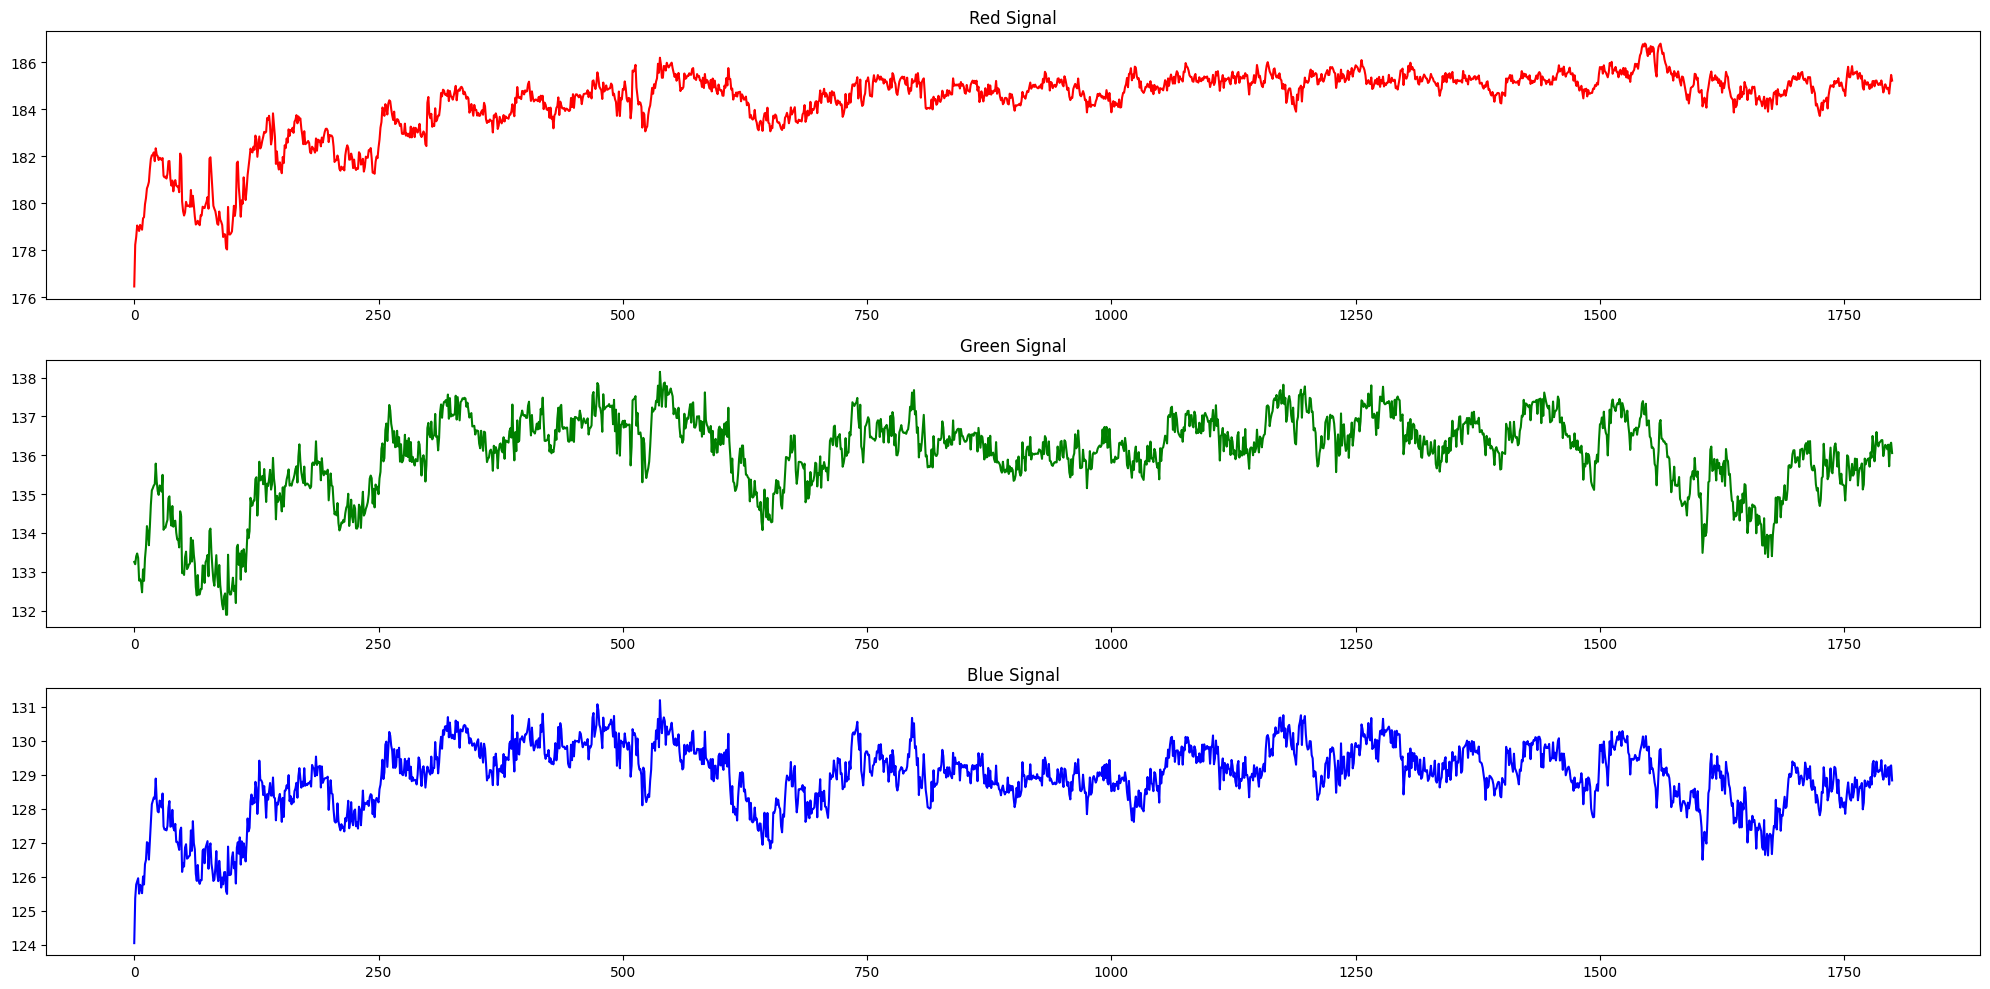

In [103]:
try:
    ## Load the Video
    file_path = os.path.join("media/toby-rgb.mp4") ## Path to the video file
    
    ## Put 0 to use the camera, or use the video file path for analyzing a video
    cap = cv2.VideoCapture(file_path) 

    if not cap.isOpened():
        print("Error: Could not open video.")
        exit()

    ## Untuk mendapatkan 60 detik video.
    while len(frame_buffer) < frame_buffer_limit:

        ## Read the frame from the camera
        ret, frame = cap.read() 
        if not ret:
            print("Error: Could not read frame.")
            break

        ## Adding the frame_buffer to the list
        frame_buffer.append(frame)


        ## Convert the frame to RGB
        ## Karena default dari OpenCV adalah BGR, kita perlu mengkonversi ke RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        ## Seting up the Mediapipe Image
        mp_image = mp.Image(
            image_format=mp.ImageFormat.SRGB,
            data=rgb_frame
        )

        ## Process the frame using the face detector
        result = face_detector.detect(mp_image)

        """
        Where the magic happens:

        Proses ini melakukan deteksi wajah pada frame video untuk mendapatkan bounding box wajah.
        Kemudian, bounding box ini digunakan untuk mendapatkan ROI (Region of Interest) dari wajah, yang kemudian digunakan 
        untuk menghitung nilai rata-rata RGB dari area tersebut. 

        Nilai rata-rata RGB ini disimpan dalam list r_signal, g_signal, dan b_signal untuk analisis lebih lanjut.
        """
        if result.detections:
            for detection in result.detections:

                ## Get the Bounding box
                bboxC = detection.bounding_box
                x, y, w, h = bboxC.origin_x, bboxC.origin_y, bboxC.width, bboxC.height

                ## Setup tipis tipis biar boxnya pas di tengah wajah
                new_x = int(x + margin_x)
                new_w = int(w * scaling_factor)
                new_h = int(h * scaling_factor)

                ## Get the ROI
                face_roi = rgb_frame[y:y+new_h, new_x:new_x+new_w]
            
                ## Draw the bounding box on the frame
                cv2.rectangle(frame, (int(x), int(y)), (int(x + new_w), int(y + new_h)), (0, 255, 0), 2)

                ## Calculate the Mean RGB values of the face ROI
                mean_rgb = cv2.mean(face_roi)[:3]
                
                # Append the combined RGB values to the respective lists
                r_signal.append(mean_rgb[0])
                g_signal.append(mean_rgb[1])
                b_signal.append(mean_rgb[2])

        # Show the frame
        cv2.imshow("frame", frame) 

        # Check if 'q' is pressed or the window is closed
        if cv2.waitKey(1) & 0xFF == ord('q') or cv2.getWindowProperty("frame", cv2.WND_PROP_VISIBLE) < 1:
            break

except Exception as e:
    print(f"An error occurred: {e}")
    cap.release()
    cv2.destroyAllWindows()

finally:
    ## Release the camera and close all windows
    cap.release()
    cv2.destroyAllWindows()

    ax, fig = plt.subplots(3, 1, figsize=(20, 10))
    fig[0].plot(r_signal, color='red')
    fig[0].set_title('Red Signal')
    fig[1].plot(g_signal, color='green')
    fig[1].set_title('Green Signal')
    fig[2].plot(b_signal, color='blue')
    fig[2].set_title('Blue Signal')
    plt.tight_layout()
    plt.show()


### Post-Processing rPPG signals
Sinyal yang diperoleh masih cukup raw (mentah), masih belum bisa dilakukan analisis lebih lanjut tanpa post-processing. 

Pada tahapan ini akan dilakukan post-processing untuk melakukan filtering sinyal dan menentukan peak dari sinyal yang merupkan tanda dari detak jantung.
\
Tahapan pertama yakni merubah sinyal RGB menjadi rPPG

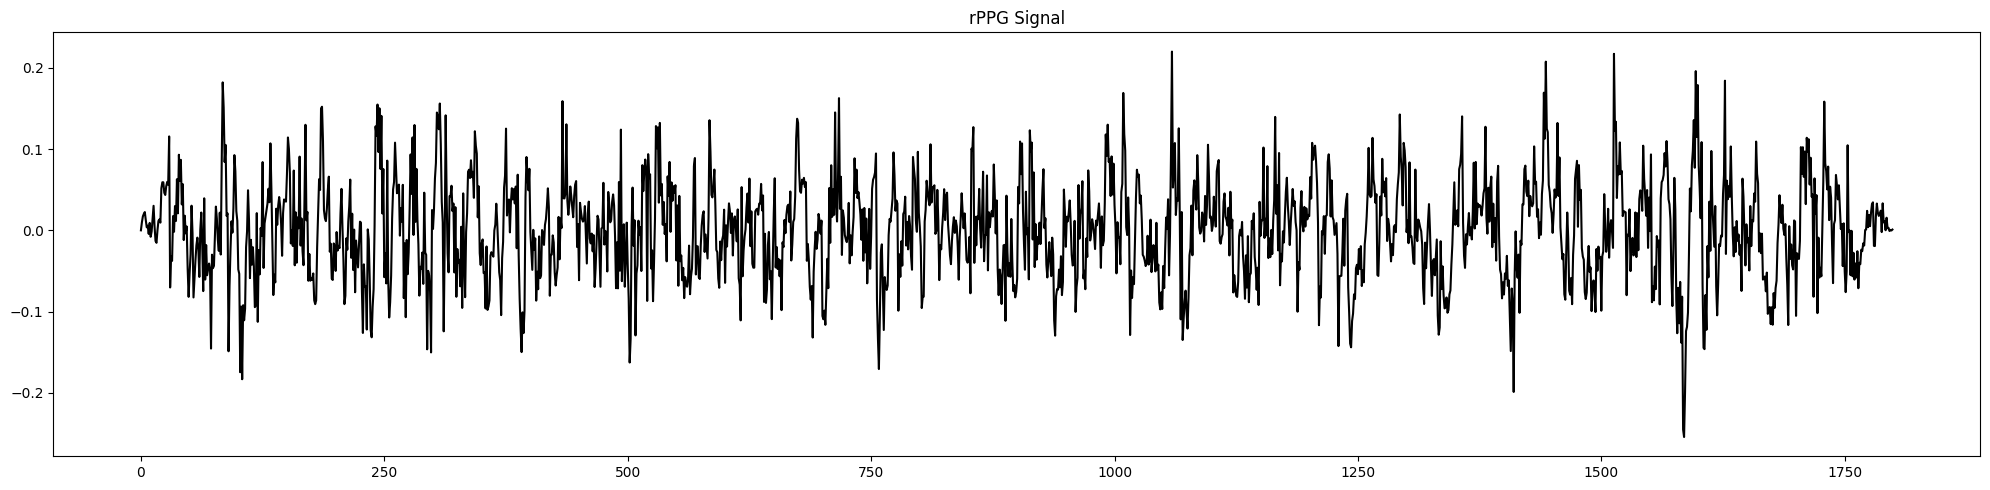

In [104]:
# Menghitung rPPG menggunakan Metode POS
rgb_signals = np.array([r_signal, g_signal, b_signal])
rgb_signals = rgb_signals.reshape(1, 3, -1)
rppg_signal = POS(rgb_signals, fps=30)
rppg_signal = rppg_signal.reshape(-1)

# 6.1 Menampilkan grafik Sinyal rPPG
plt.figure(figsize=(20, 5))
plt.plot(rppg_signal, color='black')
plt.title('rPPG Signal')
plt.tight_layout()
plt.show()

## Post-Processing dan Analysis 
Selanjutnya adalah tahapan filtering dan menentukan analisis menentukan peak / puncak dari sinyal

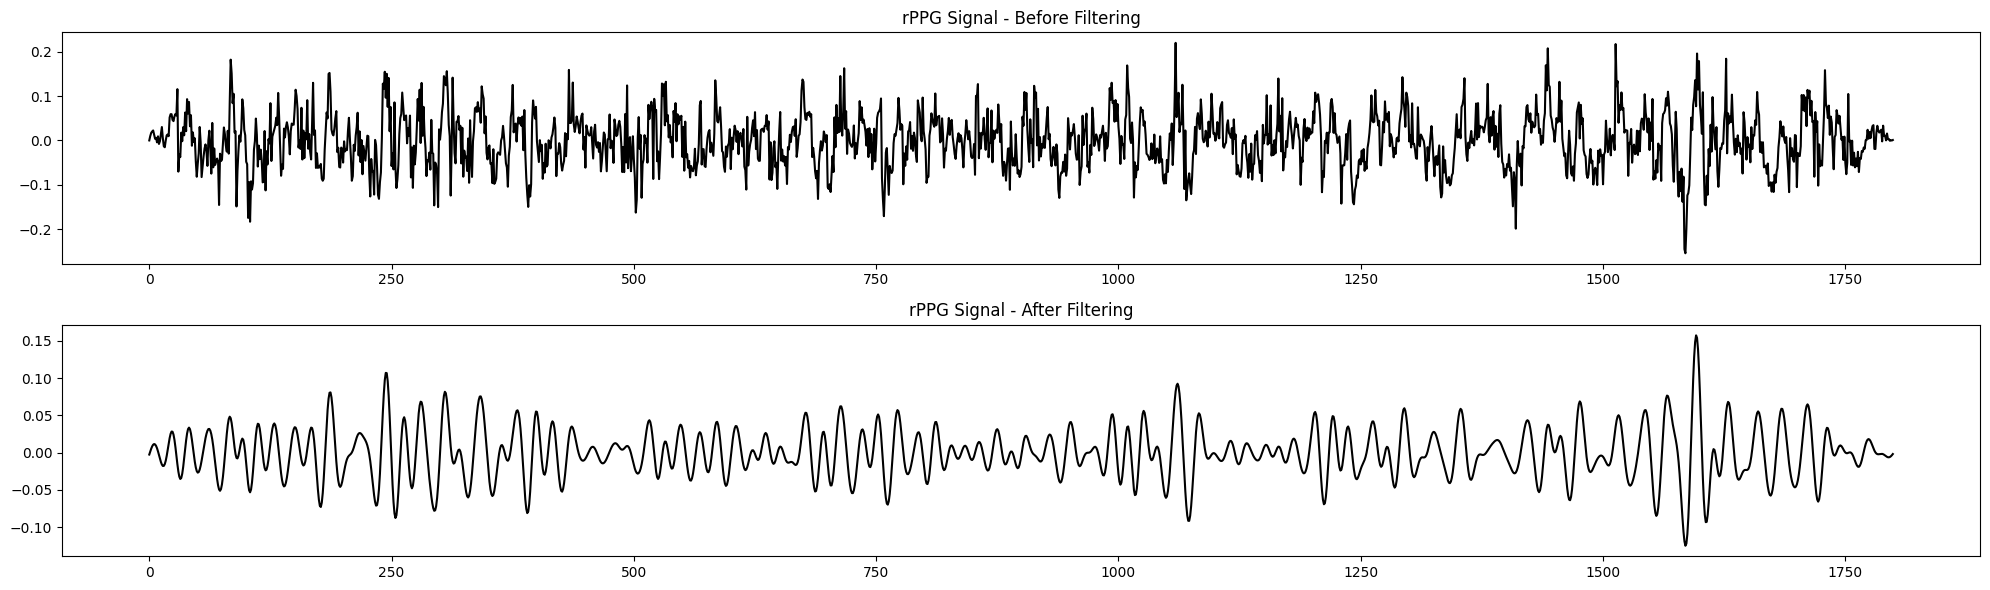

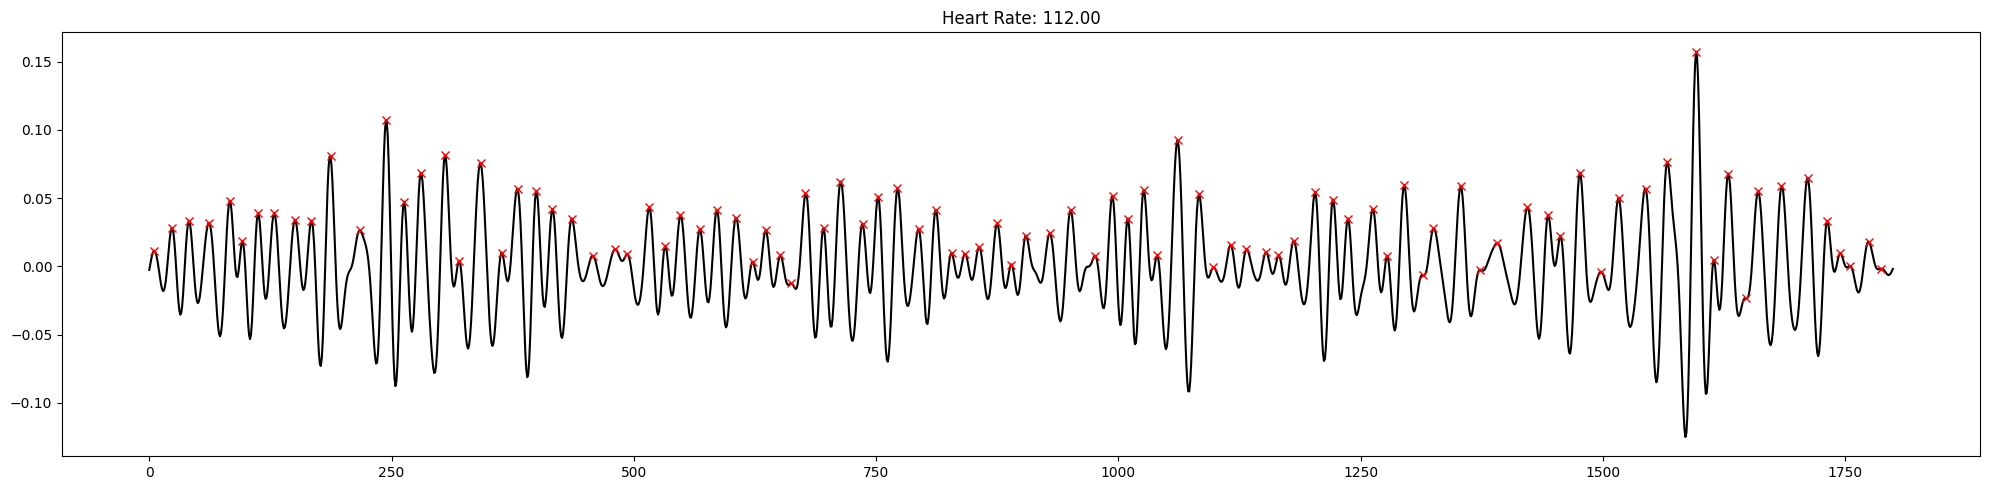

In [105]:
# Memfilter Sinyal rPPG
fs = 35; lowcut = 0.9; highcut = 2.4; order = 3
b, a = signal.butter(order, [lowcut, highcut], btype='band', fs=fs)
filtered_rppg = signal.filtfilt(b, a, rppg_signal)

fig, ax = plt.subplots(2, 1, figsize=(20, 6))
ax[0].plot(rppg_signal, color='black')
ax[0].set_title('rPPG Signal - Before Filtering')
ax[1].plot(filtered_rppg, color='black')
ax[1].set_title('rPPG Signal - After Filtering')
plt.tight_layout()
plt.show()

# Mencari puncak sinyal
peaks, _ = signal.find_peaks(
    x=filtered_rppg,
)

# Menghitung heart rate
heart_rate = 60 * len(peaks) / (len(filtered_rppg) / fs)

# Menampilkan grafik puncak sinyal
plt.figure(figsize=(20, 5))
plt.plot(filtered_rppg, color='black')
plt.plot(peaks, filtered_rppg[peaks], 'x', color='red')
plt.title(f'Heart Rate: {heart_rate:.2f}')
plt.tight_layout()
plt.show()

### Respiration - *The Rhythm Beneath the Breath* 🌬️

---

Respirasi (pernapasan) adalah salah satu sinyal fisiologis utama yang bisa diamati tanpa kontak fisik, terutama melalui **gerakan halus tubuh**, seperti naik-turunnya **bahu** saat seseorang bernapas.

Metode ini berbeda dengan PPG/RPPG yang fokus pada perubahan warna kulit. Di sini, kita memanfaatkan **gerakan mekanis** tubuh yang terekam dalam video, lalu kita ekstrak sinyal pernapasan dari pergerakan tersebut.

<div align="center">
    <img src="media/sample_toby.jpg" alt="Shoulder Breathing Motion" style="width:60%;">
    <p><small>Ilustrasi gerakan bahu saat bernapas yang digunakan untuk mengekstrak sinyal respirasi</small></p>
</div>

---

### Bagaimana Cara Mendapatkan Sinyal Ini?

Dengan bantuan **MediaPipe Pose** atau **FaceMesh**, kita bisa melacak titik-titik kunci tubuh secara real-time.

Misalnya, kita bisa ambil posisi:
- **Bahu kiri** (left shoulder)
- **Bahu kanan** (right shoulder)
- atau bahkan bagian tengah dada

Kemudian, kita ukur perubahan posisi vertikal (sumbu *y*) dari frame ke frame. Pola naik-turun ini membentuk gelombang yang merepresentasikan siklus pernapasan.


### Key Points 🔑

1. **Mediapipe Pose Landmarker**

Untuk mendapatkan sinyal respirasi dari gerakan bahu, kita akan menggunakan mediapipe lagi, terutama Pose Landmarker. Pose Landmarker sendiri akan melacak tubuh kamu dan menentukan lokasi dari bagian tubuh kamu. Untuk percobaan kali ini, kita akan menggunakan point 11 dan 12

<div align="center">
    <img src="media/pose_landmarker.png" alt="Shoulder Breathing Motion" style="width:60%;">
    <p><small>Pose Landmarker Model</small></p>
</div>

berikut representasi setiap pointnya.

```yaml
0 - nose
1 - left eye (inner)
2 - left eye
3 - left eye (outer)
4 - right eye (inner)
5 - right eye
6 - right eye (outer)
7 - left ear
8 - right ear
9 - mouth (left)
10 - mouth (right)
11 - left shoulder
12 - right shoulder
13 - left elbow
14 - right elbow
15 - left wrist
16 - right wrist
17 - left pinky
18 - right pinky
19 - left index
20 - right index
21 - left thumb
22 - right thumb
23 - left hip
24 - right hip
25 - left knee
26 - right knee
27 - left ankle
28 - right ankle
29 - left heel
30 - right heel
31 - left foot index
32 - right foot index
```

2. **Lucas-Kanade Optical Flow**

Karena MediaPipe Pose Landmarker cukup berat jika dijalankan untuk **setiap frame** pada video berdurasi panjang, kita bisa gunakan strategi kombinasi:

- **Langkah 1:** Gunakan Pose Landmarker hanya untuk mendeteksi posisi awal bahu kiri dan kanan (landmark 11 & 12).
- **Langkah 2:** Setelah posisi awal diketahui, gunakan algoritma **Lucas-Kanade Optical Flow** dari OpenCV untuk melacak pergerakan titik-titik bahu dari frame ke frame berikutnya.

<div align="center">
    <img src="media/lukas-kanade.gif" alt="Optical Flow Tracking" style="width:50%;">
    <p><small>Ilustrasi Optical Flow Tracking. Credit: <a href="https://medium.com/@siromermer/object-tracking-and-path-mapping-using-lucas-kanade-optical-flow-in-opencv-2ea018e391d4">siromer</a></small></p>
</div>

Lucas-Kanade merupakan algoritma pelacakan klasik yang efisien dan ringan, cocok untuk aplikasi real-time. Ia bekerja dengan melacak pergerakan **patch kecil** (biasanya area 15x15 piksel) di sekitar titik referensi dari satu frame ke frame berikutnya, berdasarkan pola pergerakan piksel.

Dengan melacak pergerakan **vertikal (sumbu y)** dari titik bahu, kita bisa membentuk **sinyal respirasi** yang naik dan turun sesuai dengan siklus napas.

---

3. **Ekstraksi Sinyal Respirasi dari Pergerakan Bahu**

Setelah kita mendapatkan pergerakan titik bahu dari frame ke frame, kita simpan nilai-nilai posisi vertikalnya dalam sebuah array:


### Setup Library

Sama seperti metode rPPG, sebelum memulai, alangkah baiknya kita mempersiapkan beberapa hal terlebih dahulu.

In [106]:
## Setup variables, constants and etc..
resp_signal = []
fps = 35 ## Frame rate of the camera
time_window = 60 # Time window in seconds
frame_buffer_limit = time_window * fps ## Number of frames to be processed, since toby-rgb is 60 seconds
frame_buffer = [] ## Buffer for storing frames
features = None # for storing the features optical flow.
lk_params = None ## Lucas-Kanade parameters
old_gray = None ## Old gray frame
left_x, top_y, right_x, bottom_y = None, None, None, None ## Coordinates for the ROI
STANDARD_SIZE = (640, 480)  # Pick whatever size you want


In [107]:
## Create Pose Landmarker Object

## Define the models
model_path = "models/pose_landmarker.task"
BaseOptions = mp.tasks.BaseOptions

PoseLandmarkerOptions = vision.PoseLandmarkerOptions
VisionRunningMode = vision.RunningMode

options_image = PoseLandmarkerOptions(
    base_options=BaseOptions(
        model_asset_path=model_path,
    ),
    running_mode=VisionRunningMode.IMAGE,
    num_poses=1,
    min_pose_detection_confidence=0.5,
    min_pose_presence_confidence=0.5,
    min_tracking_confidence=0.5,
    output_segmentation_masks=False
)

pose_landmarker = vision.PoseLandmarker.create_from_options(options_image)


In [108]:
# Function to get the Initial ROI for Tracking with Optical Flow
def get_initial_roi(image, landmarker, x_size = 100, y_size=100, shift_x=0, shift_y=0):
    """
    Mendapatkan ROI awal berdasarkan posisi bahu menggunakan pose detection.
    Args:
        image: Frame video input
        landmarker: Model pose detector
        x_size: Jarak piksel dari titik tengah ke tepi kiri/kanan
        y_size: Jarak piksel dari titik tengah ke tepi atas/bawah
        shift_x: Pergeseran horizontal kotak (negatif=kiri, positif=kanan)
        shift_y: Pergeseran vertikal kotak (negatif=atas, positif=bawah)
    """
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width = image.shape[:2]

    ## Create Mediapipe image
    mp_image = mp.Image(
        image_format = mp.ImageFormat.SRGB,
        data = image_rgb
    )

    ## Inference Detect Landmarks
    detection_result = landmarker.detect(mp_image)

    if not detection_result.pose_landmarks:
        raise ValueError("No pose detected in the frame")
    
    landmarks = detection_result.pose_landmarks[0]

    ## Get should position from the landmarks
    left_shoulder = landmarks[11]
    right_shoulder = landmarks[12]

    ## Calculate the center point between should before creating the ROI Bounds
    center_x = int((left_shoulder.x + right_shoulder.x) * width / 2)
    center_y = int((left_shoulder.y + right_shoulder.y) * height / 2)

    ## Apply shift to the center point (offset from the chest)
    center_x += shift_x
    center_y += shift_y

    ## Create the ROI Bounds from the center point and sizes
    left_x = max(0, center_x - x_size)
    right_x = min(width, center_x + x_size)
    top_y = max(0, center_y - y_size)
    bottom_y = min(height, center_y)

    ## Validate ROI size
    if (right_x - left_x) <= 0 or (bottom_y - top_y) <= 0:
        raise ValueError("Invalid ROI dimensions")
    
    ## Return top, left, bottom, right points
    return (left_x, top_y, right_x, bottom_y)

In [109]:
def initialize_features(frame):
    """
    Metode untuk mendapatkan nilai features untuk keperluan optical flow dan membuat object Lucas Kanade sebagai argument dari optical flow itu sendiri.
    frame: cv2Object = frame sumber dari kamera untuk melakukan deteksi ROI dada dan bahu
    """
    global features, lk_params, old_gray, left_x, top_y, right_x, bottom_y, STANDARD_SIZE   # Declare them as global to modify the outer variables

    roi_coords = get_initial_roi(frame, pose_landmarker)
    left_x, top_y, right_x, bottom_y = roi_coords
    
    frame = cv2.resize(frame, STANDARD_SIZE)
    old_frame = frame.copy()
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    roi_chest = old_gray[top_y:bottom_y, left_x:right_x]
    features = cv2.goodFeaturesToTrack(roi_chest, maxCorners=50, qualityLevel=0.2, minDistance=5, blockSize=3)
    if features is None:
        raise ValueError("No features found to track!")
    features = np.float32(features)
    features[:,:,0] += left_x
    features[:,:,1] += top_y
    old_gray = old_gray
    lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))


## Main Method 📖
Metode ini akan melakukan pendeteksian menggunakan pose landmarker untuk mendapatkan posisi dari Bahu, lalu menempatkan optical flow untuk dilakukan trakcing movement pada point di bahu.

Error: Could not read frame.


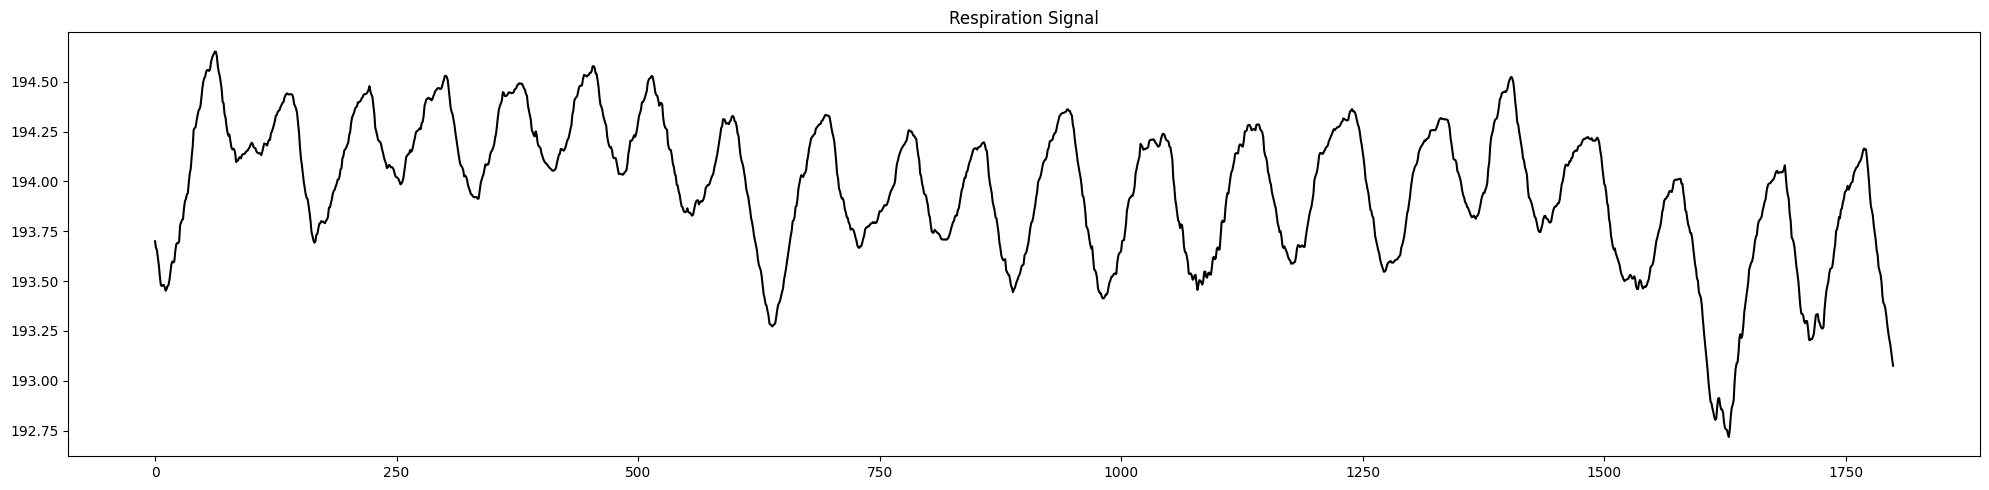

In [110]:
try:
    ## Load the Video
    file_path = os.path.join("media/toby-rgb.mp4") ## Path to the video file
    
    ## Put 0 to use the camera, or use the video file path for analyzing a video
    cap = cv2.VideoCapture(file_path) 

    if not cap.isOpened():
        print("Error: Could not open video.")
        exit()

    ## Untuk mendapatkan 60 detik video.
    while len(frame_buffer) < frame_buffer_limit:

        ## Read the frame from the camera
        ret, frame = cap.read() 
        if not ret:
            print("Error: Could not read frame.")
            break

        frame = cv2.resize(frame, STANDARD_SIZE)
        ## Adding the frame_buffer to the list
        frame_buffer.append(frame)

        if features is None:
            # Initialize ROI and feature detection
            initialize_features(frame)

        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        if len(features) > 10:
            new_features, status, error = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, features, None, **lk_params)
            good_old = features[status == 1]
            good_new = new_features[status == 1]
            mask = np.zeros_like(frame)
            for i, (new, old) in enumerate(zip(good_new, good_old)):
                a, b = new.ravel()
                c, d = old.ravel()
                mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
                frame = cv2.circle(frame, (int(a), int(b)), 3, (0, 255, 0), -1)
            frame = cv2.add(frame, mask)
            if len(good_new) > 0:
                avg_y = np.mean(good_new[:, 1])
                resp_signal.append(avg_y)
                features = good_new.reshape(-1, 1, 2)
            old_gray = frame_gray.copy()
        else:
            # Reinitialize features if tracking fails
            initialize_features(frame)

        ## Plot bounding box
        cv2.rectangle(frame, (int(left_x), int(top_y)), (int(right_x), int(bottom_y)), (0, 255, 0), 2)
        
        # Show the frame
        cv2.imshow("frame", frame) 

        # Check if 'q' is pressed or the window is closed
        if cv2.waitKey(1) & 0xFF == ord('q') or cv2.getWindowProperty("frame", cv2.WND_PROP_VISIBLE) < 1:
            break

except Exception as e:
    print(f"An error occurred: {e}")
    cap.release()
    cv2.destroyAllWindows()

finally:
    ## Release the camera and close all windows
    cap.release()
    cv2.destroyAllWindows()
    
    ## Plot the Respiration Signal
    plt.figure(figsize=(20, 5))
    plt.plot(resp_signal, color='black')
    plt.title('Respiration Signal')
    plt.tight_layout()
    plt.show()

### Tugas `Hands-On 3`

---

Kamu sudah belajar banyak mengenai metode deteksi wajah dan pose menggunakan Mediapipe, serta bagaimana cara menghitung sinyal rPPG dan sinyal pernapasan menggunakan Optical Flow. Untuk tugas Hands-on ini cukup _sederhana_ saja.

1. Berdasarkan apa yang telah kita coba mengenai metode pengambilan sinyal respirasi menggunakan mediapipe. Menggunakan video yang kalian ambil masing-masing pada tahap Pre-requisite modul ini. Lakukan proses pengambilan sinyal respirasi dan juga post-processingnya dalam menentukan laju pernafasan per menit.
2. Kita menggunakan banyak metode dalam melakukan proses pengambilan sinyal pernafasan ini seperti apa itu Lucas-Kanade Optical Flow, tetapi kita tidak cukup detail dalam membahasnya kali ini. Anggap diri kamu sebagai periset independen, lakukan riset mandiri dan jelaskan konsep-konsep dan step yang kamu gunakan sampai kamu bisa mendapatkan laju pernafasan pada video kamu, dan jangan lupa untuk membandingkan hasil data dari video kamu dengan metode ini. 

## Notes:
- Link tugas dan informasi tentang batas waktu pengumpulan akan diumumkan di halaman [web perkuliahan](https://mctm.web.id/course/2024-2025-2-if3024). Pastikan untuk rutin mengeceknya.

- Berkas yang dikumpulkan terdiri dari hasil render dalam format `PDF`. Jika hasil render notebook langsung ke PDF kurang rapih, disarankan untuk render terlebih dahulu dalam format `HTML`, lalu buka file HTML tersebut melalui browser dan simpan sebagai PDF. Selain `PDF`, unggah juga file notebook (.`ipynb`).

- Sebelum mengunggah file notebook (.ipynb), pastikan semua cell sudah dijalankan dengan jelas dan hasilnya terlihat dengan baik.
Gunakan format penamaan file sebagai berikut: `nim.pdf` untuk file PDF, dan `nim.ipynb` untuk file notebook.

- Anda diperbolehkan berdiskusi dengan teman, meminta bantuan tutor, atau menggunakan AI LLM. Namun, Anda wajib mencantumkan atribusi kepada setiap pihak yang membantu, mencantumkan sumber referensi yang digunakan, serta melampirkan transkrip lengkap percakapan dengan AI LLM di bagian paling bawah notebook.

<div align="center">
    <img src="media/sample_toby.jpg" alt="Contoh Framing" style="width:30%;">
    <p style="align: center">Reaksi Toby ketika kalian mengerjakan Hands-on 3. See you again :)</p>    
</div>